## 4.0 Machine Learning Model Building & Evaluation

This notebook focuses on building and evaluating machine learning models to predict customer churn. We will split the processed data into training and testing sets, train several classification algorithms, and assess their performance using appropriate metrics. This will help us identify the most effective model for predicting customer churn. Furthermore, we will delve into hyperparameter tuning to optimize model performance and extract feature importance to understand key churn drivers.

### 1. Setup and Data Loading

First, we import all necessary libraries and load the clean, one-hot encoded dataset (`telco_churn_processed.csv`) that was prepared in the previous steps. We also set up the directory for saving our trained models.

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib # For saving/loading models
import os

# Define your absolute data directory (same as previous notebooks)
data_dir = 'D:/My Data/Family Storages/Rudra/Education/Projects/Project 2 telco custimer churn/Data/'

# Define directory for saving models
models_dir = 'D:/My Data/Family Storages/Rudra/Education/Projects/Project 2 telco custimer churn/models/'
os.makedirs(models_dir, exist_ok=True) # Create the models directory if it doesn't exist

# --- 1. Load the Prepared Data --- (df_encoded from Step 3)
file_path_processed = os.path.join(data_dir, 'telco_churn_processed.csv')
df = pd.read_csv(file_path_processed)

print("DataFrame loaded for Model Building:")
print(df.head())
print(df.info())

DataFrame loaded for Model Building:
   gender_Male  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0            0              0        1           0       1             0   
1            1              0        0           0      34             1   
2            1              0        0           0       2             1   
3            1              0        0           0      45             0   
4            0              0        0           0       2             1   

   MultipleLines  OnlineSecurity  OnlineBackup  DeviceProtection  ...  \
0              0               0             1                 0  ...   
1              0               1             0                 1  ...   
2              0               1             1                 0  ...   
3              0               1             0                 1  ...   
4              0               0             0                 0  ...   

   Contract_One year  Contract_Two year  \
0              False    

### 2. Define Features (X) and Target (y)

We separate our dataset into the independent variables (features, `X`) that will be used for prediction, and the dependent variable (target, `y`), which is 'Churn'.

In [5]:
X = df.drop('Churn', axis=1) # All columns except 'Churn' are features
y = df['Churn']             # 'Churn' is the target variable

print("\nFeatures (X) shape:", X.shape)
print("Target (y) shape:", y.shape)


Features (X) shape: (7043, 28)
Target (y) shape: (7043,)


### 3. Split Data into Training and Testing Sets

To evaluate our models accurately on unseen data, we split the dataset into training and testing sets. We use `stratify=y` to ensure that the proportion of churned vs. non-churned customers is maintained in both sets, which is critical for imbalanced datasets like churn data. `random_state` ensures reproducibility of the split.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nTraining set shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("\nTesting set shapes:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

# Check churn distribution in training and test sets to confirm stratification was effective
print("\nChurn distribution in training set:")
print(y_train.value_counts(normalize=True) * 100)
print("\nChurn distribution in test set:")
print(y_test.value_counts(normalize=True) * 100)


Training set shapes:
X_train: (5634, 28)
y_train: (5634,)

Testing set shapes:
X_test: (1409, 28)
y_test: (1409,)

Churn distribution in training set:
Churn
0    73.464679
1    26.535321
Name: proportion, dtype: float64

Churn distribution in test set:
Churn
0    73.456352
1    26.543648
Name: proportion, dtype: float64


### 4. Model Training & Evaluation Function

To avoid repetitive code, we define a reusable function that will train any given model, make predictions, and display a comprehensive set of evaluation metrics, including accuracy, ROC AUC, classification report, and a confusion matrix. It also visualizes the confusion matrix and ROC curve for better understanding.

In [9]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    """
    Trains a given model, makes predictions, and prints evaluation metrics.
    Also visualizes the confusion matrix and ROC curve.
    """
    print(f"\n--- Training and Evaluating {model_name} ---")

    # Train the model
    model.fit(X_train, y_train)
    print(f"{model_name} trained successfully.")

    # Make predictions
    y_pred = model.predict(X_test)
    # For ROC AUC, we need probabilities of the positive class (churn=1)
    # Check if the model has predict_proba (most classifiers do)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)
    else:
        y_prob = None # Model does not support probabilities
        roc_auc = 'N/A'

    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"\nAccuracy Score ({model_name}): {accuracy:.4f}")
    if roc_auc != 'N/A':
        print(f"ROC AUC Score ({model_name}): {roc_auc:.4f}")
    print(f"\nClassification Report ({model_name}):\n{class_report}")
    print(f"\nConfusion Matrix ({model_name}):\n{conf_matrix}")

    # Visualize Confusion Matrix
    plt.figure(figsize=(7, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted No Churn (0)', 'Predicted Churn (1)'],
                yticklabels=['Actual No Churn (0)', 'Actual Churn (1)'])
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

    # Plot ROC curve only if model supports probabilities
    if y_prob is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title(f'Receiver Operating Characteristic (ROC) Curve - {model_name}', fontsize=14)
        plt.legend(loc="lower right")
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.show()

    return model

### 5. Train and Evaluate Different Classification Models

We will train and evaluate three common classification algorithms:
1.  **Logistic Regression:** A good baseline model, simple and interpretable.
2.  **Decision Tree Classifier:** Understands non-linear relationships and is good for feature importance.
3.  **Random Forest Classifier:** An ensemble method that typically offers higher accuracy by combining multiple decision trees.

#### 5.1. Logistic Regression


--- Training and Evaluating Logistic Regression ---
Logistic Regression trained successfully.

Accuracy Score (Logistic Regression): 0.8013
ROC AUC Score (Logistic Regression): 0.8424

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409


Confusion Matrix (Logistic Regression):
[[935 100]
 [180 194]]


C:\Users\Rudra\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


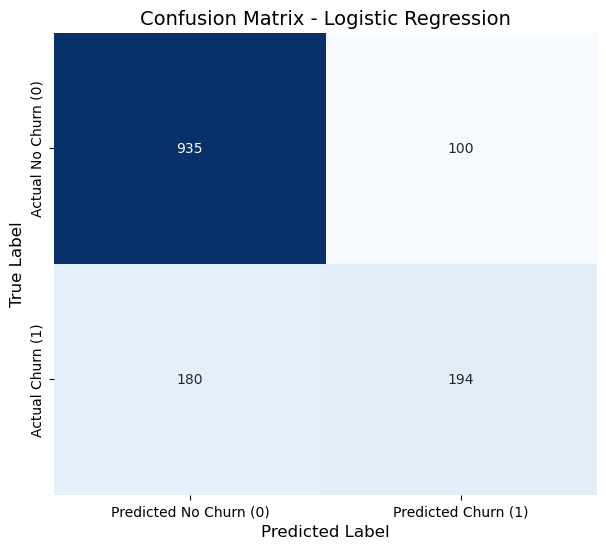

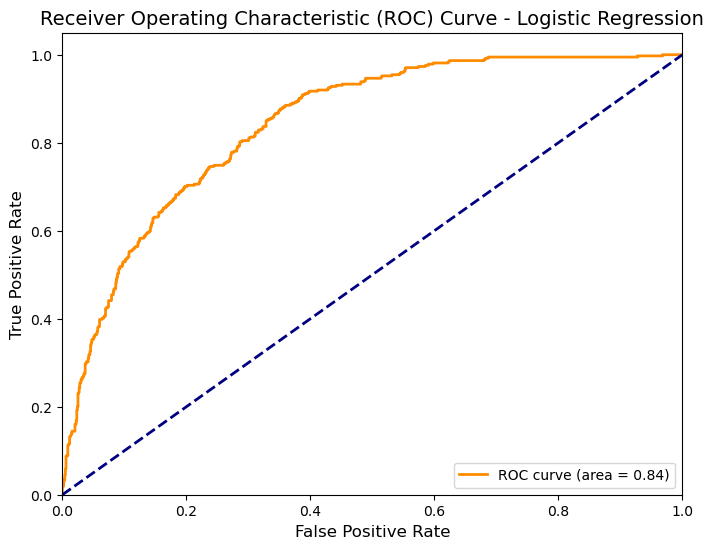

<Figure size 640x480 with 0 Axes>

In [37]:
logistic_model = LogisticRegression(random_state=42, max_iter=1000) # Increased max_iter for convergence
logistic_model = train_and_evaluate_model(logistic_model, X_train, y_train, X_test, y_test, "Logistic Regression")

plt.savefig('D:/My Data/Family Storages/Rudra/Education/Projects/Project 2 telco custimer churn/Visualization/roc_curve_logistic_regression.png', bbox_inches='tight', dpi=300)

#### 5.2. Decision Tree Classifier


--- Training and Evaluating Decision Tree ---
Decision Tree trained successfully.

Accuracy Score (Decision Tree): 0.7374
ROC AUC Score (Decision Tree): 0.6609

Classification Report (Decision Tree):
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1035
           1       0.51      0.50      0.50       374

    accuracy                           0.74      1409
   macro avg       0.66      0.66      0.66      1409
weighted avg       0.74      0.74      0.74      1409


Confusion Matrix (Decision Tree):
[[852 183]
 [187 187]]


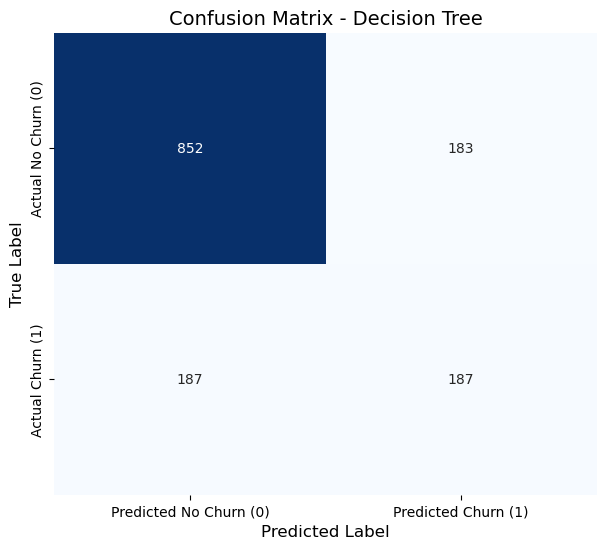

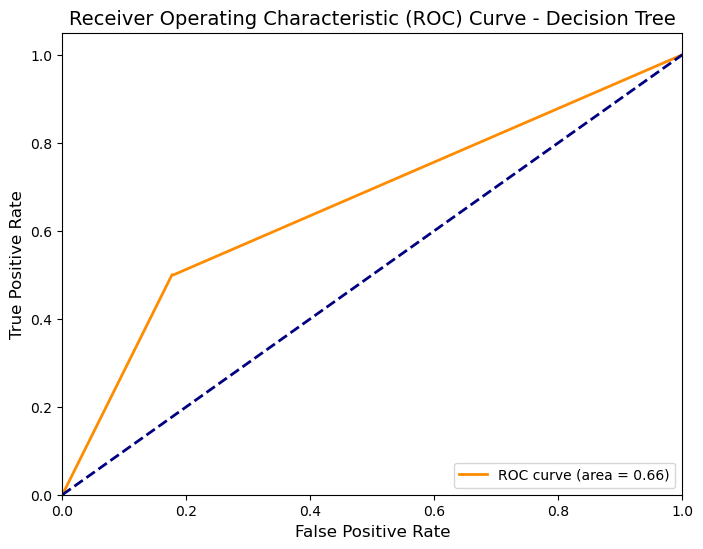

In [14]:
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model = train_and_evaluate_model(decision_tree_model, X_train, y_train, X_test, y_test, "Decision Tree")

#### 5.3. Random Forest Classifier


--- Training and Evaluating Random Forest ---
Random Forest trained successfully.

Accuracy Score (Random Forest): 0.7800
ROC AUC Score (Random Forest): 0.8236

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.61      0.48      0.54       374

    accuracy                           0.78      1409
   macro avg       0.72      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409


Confusion Matrix (Random Forest):
[[918 117]
 [193 181]]


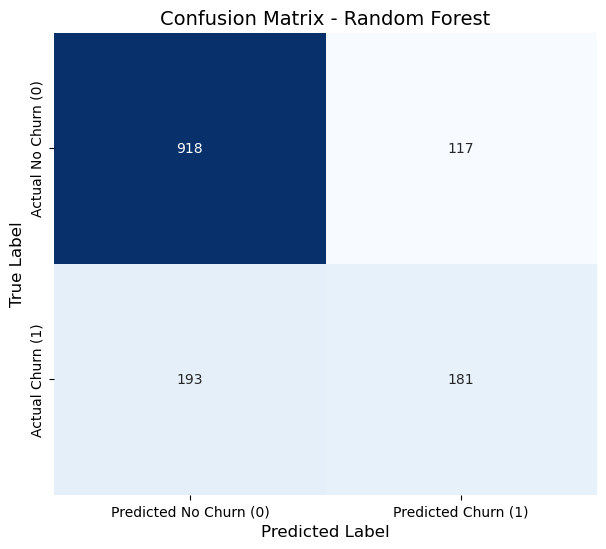

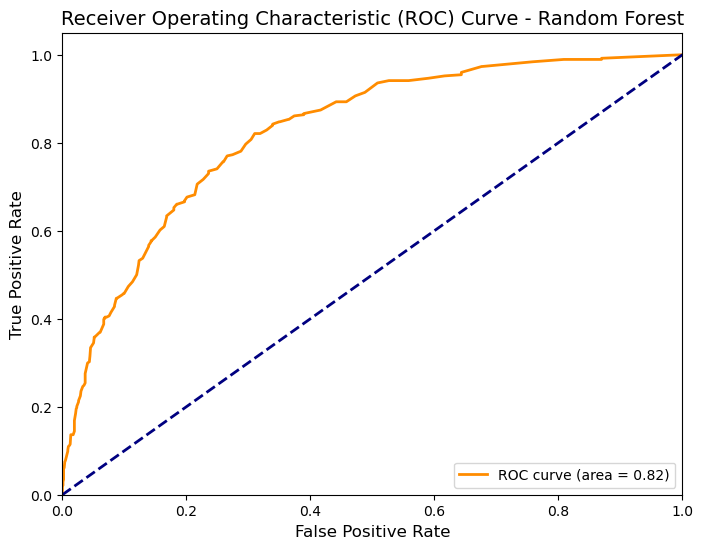

In [16]:
random_forest_model = RandomForestClassifier(random_state=42, n_estimators=100) # n_estimators can be tuned
random_forest_model = train_and_evaluate_model(random_forest_model, X_train, y_train, X_test, y_test, "Random Forest")

### 6. Hyperparameter Tuning (Example with Random Forest)

Hyperparameter tuning is crucial for optimizing model performance. We'll use `GridSearchCV` to systematically search for the best combination of hyperparameters for our Random Forest model based on the ROC AUC score (a robust metric for imbalanced classification). This process involves training multiple models with different parameter settings via cross-validation.

In [18]:
print("\n--- Performing Hyperparameter Tuning for Random Forest ---")

# Define the parameter grid for GridSearchCV
# This process can be computationally intensive and take some time to run.
param_grid = {
    'n_estimators': [50, 100, 200],         # Number of trees in the forest
    'max_depth': [None, 10, 20],            # Maximum depth of the tree (None means unlimited)
    'min_samples_split': [2, 5],            # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2]              # Minimum number of samples required to be at a leaf node
}

# Initialize GridSearchCV
# cv=5: 5-fold cross-validation
# scoring='roc_auc': Optimize for ROC AUC score
# n_jobs=-1: Use all available CPU cores for parallel processing
# verbose=1: Display progress messages
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

print("\nBest parameters found:", grid_search.best_params_)
print("Best ROC AUC score (on training data with CV):", grid_search.best_score_)


--- Performing Hyperparameter Tuning for Random Forest ---
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best ROC AUC score (on training data with CV): 0.8433014745129729


### 7. Evaluate the Best Performing Model

After hyperparameter tuning, we take the best estimator found by `GridSearchCV` and evaluate its performance on the unseen test set. This gives us a final, unbiased assessment of the optimized model's capabilities.


--- Evaluating Best Random Forest Model (after tuning) on Test Set ---

--- Training and Evaluating Best Random Forest ---
Best Random Forest trained successfully.

Accuracy Score (Best Random Forest): 0.8055
ROC AUC Score (Best Random Forest): 0.8436

Classification Report (Best Random Forest):
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.68      0.51      0.58       374

    accuracy                           0.81      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.79      0.81      0.80      1409


Confusion Matrix (Best Random Forest):
[[946  89]
 [185 189]]


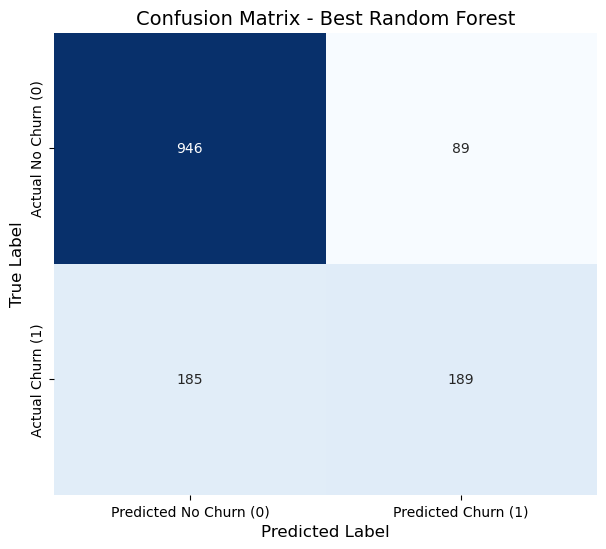

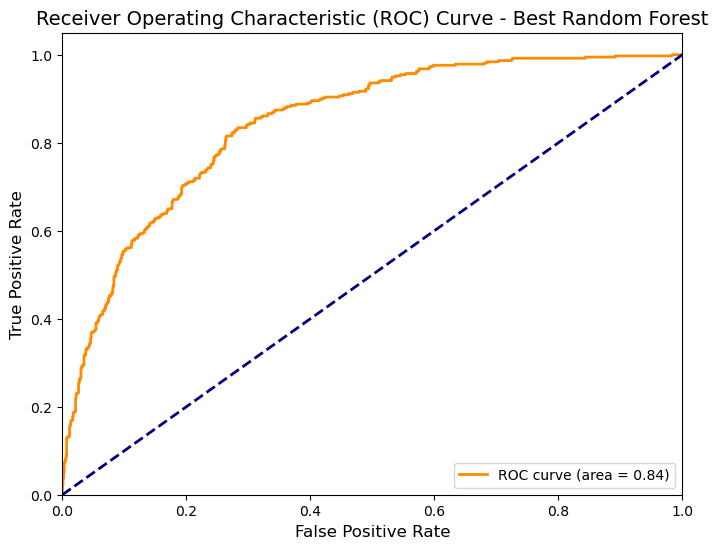

In [20]:
# Use the best estimator found by GridSearchCV
best_random_forest_model = grid_search.best_estimator_

# Evaluate the best model on the test set using our defined function
print("\n--- Evaluating Best Random Forest Model (after tuning) on Test Set ---")
best_random_forest_model = train_and_evaluate_model(best_random_forest_model, X_train, y_train, X_test, y_test, "Best Random Forest")

### 8. Feature Importance

For tree-based models like Decision Tree and Random Forest, we can extract feature importances. This helps us understand which features contribute most to the model's predictions, providing valuable business insights into the primary drivers of customer churn.


--- Feature Importance from Best Random Forest Model ---
                           Feature  Importance
4                           tenure    0.183997
15                    TotalCharges    0.155426
14                  MonthlyCharges    0.129716
16     InternetService_Fiber optic    0.090961
19               Contract_Two year    0.067337
21  PaymentMethod_Electronic check    0.062936
18               Contract_One year    0.035298
17              InternetService_No    0.031599
7                   OnlineSecurity    0.027034
13                PaperlessBilling    0.026456
10                     TechSupport    0.020647
6                    MultipleLines    0.016544
8                     OnlineBackup    0.014633
3                       Dependents    0.014457
2                          Partner    0.013973


C:\Users\Rudra\AppData\Local\Temp\ipykernel_9472\2090001933.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='viridis')


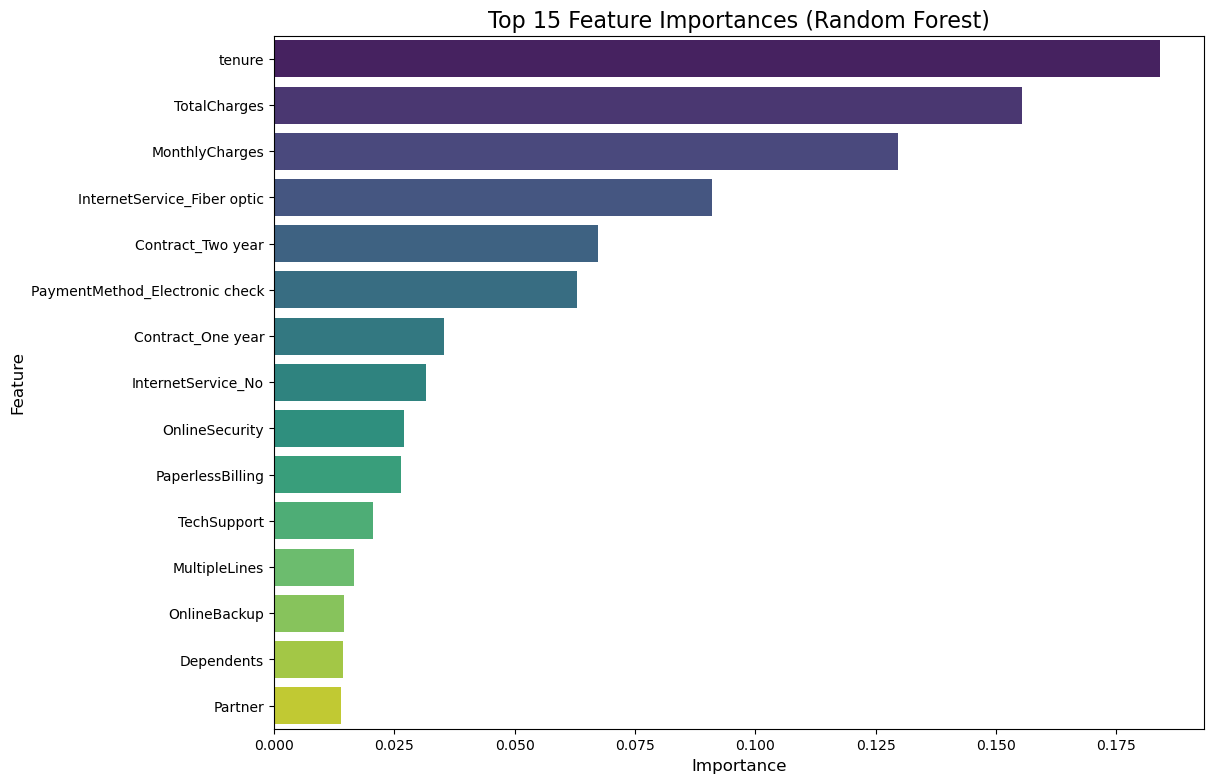


Feature importances saved to: 'D:/My Data/Family Storages/Rudra/Education/Projects/Project 2 telco custimer churn/Data/feature_importances.csv'


In [22]:
print("\n--- Feature Importance from Best Random Forest Model ---")

feature_importances = best_random_forest_model.feature_importances_
features = X.columns # Get the names of the features

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df.head(15)) # Print top 15 most important features

# Visualize Feature Importance
plt.figure(figsize=(12, 9)) # Adjusted figure size for better readability
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='viridis')
plt.title('Top 15 Feature Importances (Random Forest)', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# --- NEW: Save feature importances to CSV for dashboarding ---
importance_df_path = os.path.join(data_dir, 'feature_importances.csv')
importance_df.to_csv(importance_df_path, index=False)
print(f"\nFeature importances saved to: '{importance_df_path}'")

### 9. Save the Best Performing Model

Once the best model is identified and evaluated, it's good practice to save it. This allows you to load the trained model later for making new predictions without retraining, or for deployment in a production environment.

In [24]:
model_filename = os.path.join(models_dir, 'best_churn_prediction_model.joblib')
joblib.dump(best_random_forest_model, model_filename)
print(f"\nBest model saved to: {model_filename}")


Best model saved to: D:/My Data/Family Storages/Rudra/Education/Projects/Project 2 telco custimer churn/models/best_churn_prediction_model.joblib


### Outcomes & Next Steps

##### Outcomes:
###### Successfully trained and evaluated multiple machine learning models for churn prediction.
###### Used techniques like train-test split, hyperparameter tuning (GridSearchCV), and assessed performance using various metrics (Accuracy, Precision, Recall, F1-Score, ROC AUC, Confusion Matrix).
###### Identified key features driving churn and saved your best performing model for future use.